In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
tqdm.pandas()
from shapely.geometry import Point

In [3]:
def crossref(df, gdf):
    shapes = gdf.geometry
    def get_polygon(row):
        point = Point(row['LONGITUDE'], row['LATITUDE'])
        contain = shapes.apply(lambda x: x.contains(point))
        if contain.any():
            return contain[contain].index[0]
        else:
            return None
    
    df["id_poly"] = df.progress_apply(get_polygon, axis = 1)
    return df
    

In [4]:
def groupby_month(df):
    df["year"] = df.date.dt.year
    df["month"] = df.date.dt.month
    df = df.groupby(["id_poly", "year", "month"]).size().reset_index()
    df.columns = ["id_poly", "year", "month", "count"]
    df["id_poly"] = df["id_poly"].astype(int)
    return df

def transform_month_to_ts(df):
    start_year = df.year.min()
    start_month = df[df.year == start_year].month.min()
    end_year = df.year.max()
    end_month = df[df.year == end_year].month.max()
    n_months = (end_year - start_year) * 12 + end_month - start_month + 1

    id_poly = df.id_poly
    n_poly = id_poly.max() + 1

    ts = np.zeros((n_poly, n_months))
    k = 0
    for m in range(start_month, 13):
        filtered = df[(df.year == start_year) & (df.month == m)]
        if len(filtered) == ts.shape[0]:
            ts[:, k] = filtered["count"]
        elif len(filtered) > 0:
            ts[filtered.id_poly, k] = filtered["count"]
        k += 1

    for y in range(start_year + 1, end_year):
        for m in range(1, 13):
            filtered = df[(df.year == y) & (df.month == m)]
            if len(filtered) == ts.shape[0]:
                ts[:, k] = filtered["count"]
            elif len(filtered) > 0:
                ts[filtered.id_poly, k] = filtered["count"]
            k += 1

    for m in range(1, end_month + 1):
        filtered = df[(df.year == end_year) & (df.month == m)]
        if len(filtered) == ts.shape[0]:
            ts[:, k] = filtered["count"]
        elif len(filtered) > 0:
            ts[filtered.id_poly, k] = filtered["count"]
        k += 1
        
    return ts


def groupby_day(df):
    day_ns = 60*60*24*10**9
    df["date_int"] = df.date.astype(int)
    df["date_int"] = df.date_int / day_ns
    df["date_int"] = df.date_int.astype(int)    
    df = df.groupby(["id_poly", "date_int"]).size().reset_index()
    df.columns = ["id_poly", "date_int", "count"]
    df["id_poly"] = df["id_poly"].astype(int)
    df = df.sort_values(["id_poly", "date_int"])
    return df


def transform_day_to_ts(df):
    min_date = df.date_int.min()
    max_date = df.date_int.max()
    n_days = max_date - min_date + 1
    id_poly = df.id_poly
    n_poly = id_poly.max() + 1
    ts = np.zeros((n_poly, n_days))
    k = 0
    for day in range(min_date, max_date + 1):
        filtered = df[df.date_int == day]
        if len(filtered) == ts.shape[0]:
            ts[:, k] = filtered["count"]
        else:
        # fill missing values with 0
            ts[:, k] = 0
            ts[filtered.id_poly, k] = filtered["count"]
        k += 1

    return ts


## Climate

https://basedosdados.org/dataset/782c5607-9f69-4e12-b0d5-aa0f1a7a94e2?table=28d16282-d100-4ea8-9dde-36c05c8f1ca2

In [2]:
df = pd.read_csv("data/estacao.csv")
print(df.shape)

(612, 7)


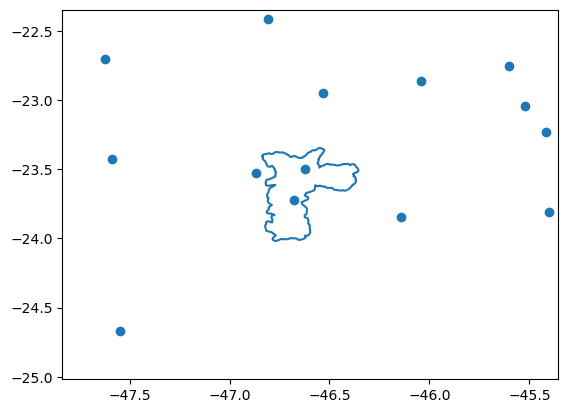

In [14]:
# read geojson
gdf = gpd.read_file("data/countour.geojson")
# get bbox
bbox = gdf.total_bounds
plt.scatter(df['longitude'], df['latitude'])
plt.xlim(bbox[0] - 1, bbox[2] + 1)
plt.ylim(bbox[1] - 1, bbox[3] + 1)
plt.plot(gdf.geometry[0].exterior.xy[0], gdf.geometry[0].exterior.xy[1])
plt.show()


## Waze

In [3]:
N = 100000
df = pd.read_csv("data/time_series/waze-alerts.csv")
df = df.sample(N)
print(df.shape)
df.columns

(100000, 6)


Index(['geo', 'ts', ' type', ' subtype', ' reliability', ' confidence'], dtype='object')

In [4]:
df["date"] = pd.to_datetime(df["ts"])
df["LONGITUDE"] = df["geo"].apply(lambda x : x.split("(")[1].split(" ")[0])
df["LATITUDE"] = df["geo"].apply(lambda x : x.split(" ")[1].split(")")[0])
df.LONGITUDE = df.LONGITUDE.astype(float)
df.LATITUDE = df.LATITUDE.astype(float)

In [8]:
df[" type"].value_counts()

 type
JAM              71450
WEATHERHAZARD    22477
ACCIDENT          3073
HAZARD            2168
ROAD_CLOSED        832
Name: count, dtype: int64

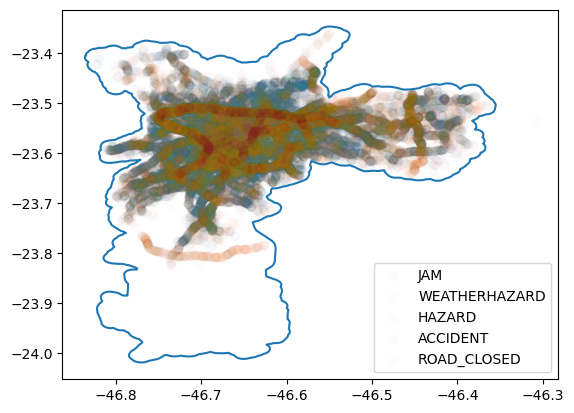

In [12]:
countour = gpd.read_file("data/countour.geojson")
plt.plot(countour.geometry[0].exterior.xy[0], countour.geometry[0].exterior.xy[1])
for ty in df[" type"].unique():
    df_filter = df[df[" type"] == ty]
    plt.scatter(df_filter['LONGITUDE'], df_filter['LATITUDE'], alpha = 0.01, label = ty)
plt.legend()
plt.show()

In [17]:
gdf = gpd.read_file("data/shapefiles/sp_distrit.shp")
df = crossref(df, gdf)
df.to_csv("data/geo_data/waze_alerts_sp_distrit.csv", index = False)

100%|██████████| 100000/100000 [01:41<00:00, 983.37it/s]


In [18]:
gdf = gpd.read_file("data/shapefiles/sp_center_census.shp")
df = crossref(df, gdf)
df.to_csv("data/geo_data/waze_alerts_sp_center_census.csv", index = False)

100%|██████████| 100000/100000 [1:53:48<00:00, 14.64it/s] 


### Distrit

In [111]:
df = pd.read_csv("data/geo_data/waze_alerts_sp_distrit.csv")
df["date"] = pd.to_datetime(df["date"])
df = df[df.date < "2024-01-01"]
df = df[df.date >= "2019-04-01"]
df = df.dropna(subset = ["id_poly"])

In [113]:
df_month = groupby_month(df)
ts_month = transform_month_to_ts(df_month)
np.save("data/time_series/waze_alerts_sp_distrit_month.npy", ts_month)

In [114]:
df = df[df.date < "2020-01-01"]
df_day = groupby_day(df)
ts_day = transform_day_to_ts(df_day)
np.save("data/time_series/waze_alerts_sp_distrit_day.npy", ts_day)

### Center census

In [115]:
df = pd.read_csv("data/geo_data/waze_alerts_sp_center_census.csv")
df["date"] = pd.to_datetime(df["date"])
df = df[df.date < "2024-01-01"]
df = df[df.date >= "2019-04-01"]
df = df.dropna(subset = ["id_poly"])

In [116]:
df_month = groupby_month(df)
ts_month = transform_month_to_ts(df_month)
np.save("data/time_series/waze_alerts_sp_center_census_month.npy", ts_month)

In [117]:
df = df[df.date < "2020-01-01"]
df_day = groupby_day(df)
ts_day = transform_day_to_ts(df_day)
np.save("data/time_series/waze_alerts_sp_center_census_day.npy", ts_day)

## Crime theft

In [19]:
df = pd.read_csv("data/time_series/furto_celular_2018_2022.csv", sep = ";")
# drop columns with more than 0.1 of missing values
df["date"] = pd.to_datetime(df.DATAOCORRENCIA, format='%d/%m/%Y', errors='coerce')
df = df.dropna(thresh=0.9*len(df), axis=1)
df = df.dropna()
df = df.drop(columns = ["ANO_BO", "DATAOCORRENCIA"], axis = 1)
df = df[df.date > "2018-01-01"]
df = df.reset_index(drop=True)
df.shape

/tmp/ipykernel_63769/2216112243.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/time_series/furto_celular_2018_2022.csv", sep = ";")


(389397, 13)

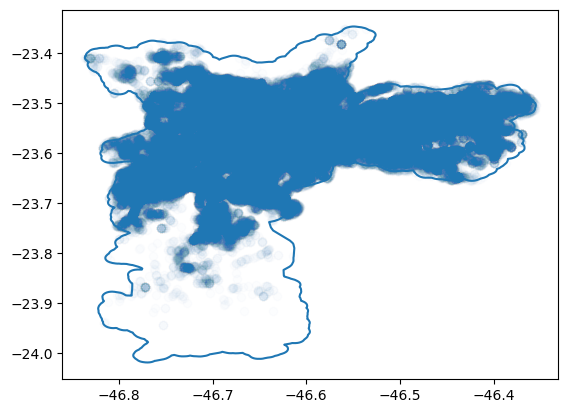

In [19]:
countour = gpd.read_file("data/countour.geojson")
plt.plot(countour.geometry[0].exterior.xy[0], countour.geometry[0].exterior.xy[1])
plt.scatter(df['LONGITUDE'], df['LATITUDE'], alpha = 0.01)
plt.show()

In [20]:
gdf = gpd.read_file("data/shapefiles/sp_distrit.shp")
df = crossref(df, gdf)
df.to_csv("data/geo_data/crime_sp_distrit.csv", index = False)

100%|██████████| 389397/389397 [06:28<00:00, 1001.67it/s]


In [21]:
gdf = gpd.read_file("data/shapefiles/sp_center_census.shp")
df = crossref(df, gdf)
df.to_csv("data/geo_data/crime_sp_center_census.csv", index = False)

100%|██████████| 389397/389397 [7:31:46<00:00, 14.37it/s]   


### Distrit

In [5]:
df = pd.read_csv("data/geo_data/crime_sp_distrit.csv")
df["date"] = pd.to_datetime(df["date"])
df = df[df.date < "2024-01-01"]
df = df[df.date >= "2019-04-01"]
df = df.dropna(subset = ["id_poly"])

In [6]:
df_month = groupby_month(df)
ts_month = transform_month_to_ts(df_month)
np.save("data/time_series/crime_sp_distrit_month.npy", ts_month)

In [8]:
df = df[df.date < "2020-01-01"]
df_day = groupby_day(df)
ts_day = transform_day_to_ts(df_day)
np.save("data/time_series/crime_sp_distrit_day.npy", ts_day)

### Center census

In [9]:
df = pd.read_csv("data/geo_data/crime_sp_center_census.csv")
df["date"] = pd.to_datetime(df["date"])
df = df[df.date < "2024-01-01"]
df = df[df.date >= "2019-04-01"]
df = df.dropna(subset = ["id_poly"])

In [10]:
df_month = groupby_month(df)
ts_month = transform_month_to_ts(df_month)
np.save("data/time_series/crime_sp_center_census_month.npy", ts_month)

In [11]:
df = df[df.date < "2020-01-01"]
df_day = groupby_day(df)
ts_day = transform_day_to_ts(df_day)
np.save("data/time_series/crime_sp_center_census_day.npy", ts_day)

## Crime robbery